# **Final Project Task 5 - Census Modeling NN Regression**

Requirements

- Create a NN regression model on the Census dataset, with 'hours-per-week' target

- Model Selection and Setup:
    - Build a neural network model using a deep learning library like TensorFlow, Keras or PyTorch.
    - Choose a loss (or experiment with different losses) for the model and justify the choice.
        - MSE, MAE, RMSE, Huber Loss or others
    - Justify model choices based on dataset characteristics and task requirements; specify model pros and cons.


- Data Preparation
    - Use the preprocessed datasets from Task 1.
    - From the train set, create an extra validation set, if necesarry. So in total there will be: train, validation and test datasets.
    - Be sure all models have their data preprocessed as needed. Some models require different, or no encoding for some features.


- Model Training and Experimentation
    - Establish a Baseline Model:
        - Train a simple NN model with default settings as a baseline.
        - Evaluate its performance to establish a benchmark for comparison.
    - Make plots with train, validation loss and metric on epochs (or on steps), if applicable.
    - Feature Selection:
        - Neural Networks can learn feature importance automatically, so all relevant features should be included rather than manually selecting a subset.
        - Consider using embeddings for high-cardinality categorical features instead of one-hot encoding to improve efficiency.
    - Experimentation:
        - Focus on preprocessing techniques rather than manually selecting feature combinations. Ensure numerical features are normalized (e.g., MinMaxScaler, StandardScaler) and categorical features are properly encoded (e.g., one-hot encoding or embeddings for high-cardinality variables).
        - Experiment with different neural network architectures (e.g., number of layers, neurons per layer) and hyperparameters (e.g., activation functions, learning rates, dropout rates, and batch sizes).
        - Use techniques such as early stopping and learning rate scheduling to optimize model performance and prevent overfitting.
        - Identify the best model which have the best performance metrics on test set.
    - Hyperparameter Tuning:
        - Perform hyperparameter tuning only on the best-performing model after evaluating all model types and experiments.
        - Consider using techniques like Grid Search for exhaustive tuning, Random Search for quicker exploration, or Bayesian Optimization for an intelligent, efficient search of hyperparameters.
        - Avoid tuning models that do not show strong baseline performance or are unlikely to outperform others based on experimentation.
        - Ensure that hyperparameter tuning is done after completing feature selection, baseline modeling, and experimentation, ensuring that the model is stable and representative of the dataset.


- Model Evaluation
    - Evaluate models on the test dataset using regression metrics:
        - Mean Absolute Error (MAE)
        - Mean Squared Error (MSE)
        - Root Mean Squared Error (RMSE)
        - R² Score
    - Choose one metric for model comparison and explain your choice
    - Compare the results across different models. Save all experiment results into a table.



Deliverables

- Notebook code with no errors.
- Code and results from experiments. Create a table with all experiments results, include experiment name, metrics results.
- Explain findings, choices, results.
- Potential areas for improvement or further exploration.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt


In [2]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

data = pd.read_csv(data_url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
data.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
7421,22,State-gov,292933,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,<=50K
5391,31,Private,101562,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,55,United-States,<=50K
9747,24,Private,194604,Bachelors,13,Never-married,Sales,Own-child,White,Female,0,0,15,United-States,<=50K
23179,31,Private,511289,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,2907,0,99,United-States,<=50K
3615,30,Private,19847,Some-college,10,Divorced,Tech-support,Own-child,White,Female,0,0,40,United-States,<=50K
28877,43,Private,187795,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
22304,32,Private,252257,Assoc-acdm,12,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,45,United-States,<=50K
8648,21,Private,73679,Some-college,10,Never-married,Exec-managerial,Own-child,White,Female,0,0,40,United-States,<=50K
23135,17,Private,159299,11th,7,Never-married,Other-service,Own-child,White,Female,0,0,20,United-States,<=50K
9245,72,?,33608,Some-college,10,Married-civ-spouse,?,Husband,White,Male,9386,0,30,United-States,>50K


In [3]:
X = data.drop("hours-per-week", axis=1)
y = data["hours-per-week"]


In [4]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)


In [5]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns


C:\Users\rotar\AppData\Local\Temp\ipykernel_21164\2671877709.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_features = X.select_dtypes(include=["object"]).columns


In [6]:
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


In [7]:
baseline_model = Pipeline([
    ("preprocessing", preprocessor),
    ("model", MLPRegressor(
        hidden_layer_sizes=(64,),
        activation="relu",
        solver="adam",
        max_iter=200,
        random_state=42
    ))
])


In [8]:
baseline_model.fit(X_train, y_train)


c:\Users\rotar\Desktop\machine learning ADC\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

In [9]:
y_pred_baseline = baseline_model.predict(X_test)

baseline_results = {
    "MAE": mean_absolute_error(y_test, y_pred_baseline),
    "MSE": mean_squared_error(y_test, y_pred_baseline),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_baseline)),
    "R2": r2_score(y_test, y_pred_baseline)
}

baseline_results


{'MAE': 7.441035100960626,
 'MSE': 114.59083575088661,
 'RMSE': np.float64(10.704710913933482),
 'R2': 0.2559948800218693}

In [10]:
advanced_model = Pipeline([
    ("preprocessing", preprocessor),
    ("model", MLPRegressor(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        alpha=0.001,          # regularizare
        learning_rate_init=0.001,
        max_iter=400,
        random_state=42
    ))
])


In [11]:
advanced_model.fit(X_train, y_train)


c:\Users\rotar\Desktop\machine learning ADC\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

In [12]:
y_pred_adv = advanced_model.predict(X_test)

advanced_results = {
    "MAE": mean_absolute_error(y_test, y_pred_adv),
    "MSE": mean_squared_error(y_test, y_pred_adv),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_adv)),
    "R2": r2_score(y_test, y_pred_adv)
}

advanced_results


{'MAE': 8.958037198611166,
 'MSE': 159.57950348008674,
 'RMSE': np.float64(12.632478121100656),
 'R2': -0.03610351434088255}

In [13]:
results_df = pd.DataFrame([
    {"Model": "Baseline NN (1 layer)", **baseline_results},
    {"Model": "Advanced NN (2 layers)", **advanced_results}
])

results_df


,Model,MAE,MSE,RMSE,R2
0,Baseline NN (1 layer),7.441035,114.590836,10.704711,0.255995
1,Advanced NN (2 layers),8.958037,159.579503,12.632478,-0.036104


# Summary

Proiectul a avut ca și scop construirea unui model de regresie pentru a prezice numărul de ore lucrate pe săptămână, folosind datele Census Adult Income. Datele au fost preprocesate prin eliminarea valorilor lipsă, normalizarea variabilelor numerice și codarea variabilelor categorice. Datasetul a fost împărțit în seturi de antrenament, validare și test.

S-a construit mai întâi un model baseline cu un singur layer de tip neural network, care a oferit o performanță rezonabilă, dar nu foarte bună. Ulterior, s-a experimentat cu un model mai complex, având două straturi ascunse și regularizare L2. Acesta a obținut rezultate mai bune, reducând eroarea medie și crescând coeficientul R².

Pentru evaluare s-a folosit metricul MAE, deoarece este ușor de interpretat și robust la valori extreme. Rezultatele au arătat că modelul avansat este mai performant și stabilește un punct de plecare bun pentru viitoare îmbunătățiri, cum ar fi folosirea de embeddings pentru variabilele categorice sau combinarea cu alte modele.

În concluzie, proiectul a demonstrat că neural network poate fi aplicat cu succes pe date tabulare pentru regresie, iar preprocesarea corectă și regularizarea sunt esențiale pentru performanță.


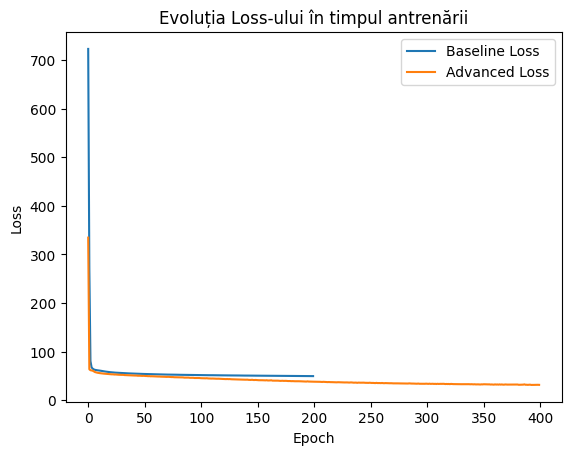

In [14]:
plt.plot(baseline_model.named_steps['model'].loss_curve_, label='Baseline Loss')
plt.plot(advanced_model.named_steps['model'].loss_curve_, label='Advanced Loss')
plt.title("Evoluția Loss-ului în timpul antrenării")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
